In [1]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [2]:
# More imports
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [4]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [5]:
df.tail()

# From 2013 to 2018

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


In [11]:
# Start by doing the WRONG thing - trying to predict the price itself
series = df['close'].values.reshape(-1, 1)
series

array([[28.185],
       [28.07 ],
       [28.13 ],
       ...,
       [54.69 ],
       [55.61 ],
       [54.46 ]])

In [12]:
# Data normilizing
# Note: Here we do not bother where the true boundary is, this is just approx
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [16]:
# Build the dataset
T = 10
D = 1 
X = []
Y = []

for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data is N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1249, 10, 1) Y.shape (1249,)


In [19]:
# Autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)

model = Model(i, x)
model.compile(loss='mse', optimizer=Adam(learning_rate=0.1))

# Train
r = model.fit(
    X[:-N//2], 
    Y[:-N//2],
    epochs=80, 
    validation_data=(X[-N//2:], Y[-N//2:]))

20/20 [==============================] - 0s 7ms/step - loss: 0.0051 - val_loss: 0.0163
Epoch 62/80
20/20 [==============================] - 0s 7ms/step - loss: 0.0051 - val_loss: 0.0146
Epoch 63/80
20/20 [==============================] - 0s 7ms/step - loss: 0.0052 - val_loss: 0.0140
Epoch 64/80
20/20 [==============================] - 0s 7ms/step - loss: 0.0051 - val_loss: 0.0230
Epoch 65/80
20/20 [==============================] - 0s 7ms/step - loss: 0.0056 - val_loss: 0.0175
Epoch 66/80
20/20 [==============================] - 0s 7ms/step - loss: 0.0056 - val_loss: 0.0150
Epoch 67/80
20/20 [==============================] - 0s 7ms/step - loss: 0.0053 - val_loss: 0.0192
Epoch 68/80
20/20 [==============================] - 0s 7ms/step - loss: 0.0055 - val_loss: 0.0243
Epoch 69/80
20/20 [==============================] - 0s 8ms/step - loss: 0.0056 - val_loss: 0.0142
Epoch 70/80
20/20 [==============================] - 0s 7ms/step - loss: 0.0062 - val_loss: 0.0155
Epoch 71/80
20/20 [===

<function matplotlib.pyplot.legend>

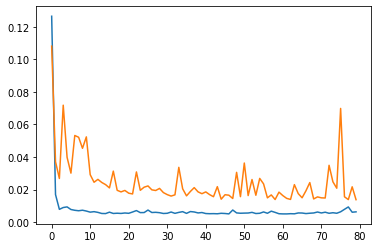

In [24]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend

(1249, 1)


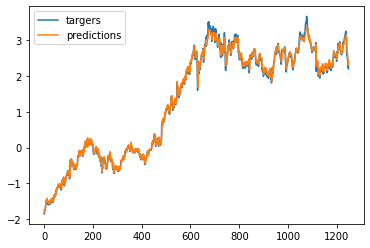

In [25]:
# One step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:, 0]

plt.plot(Y, label = 'targers')
plt.plot(predictions, label = 'predictions')
plt.legend()
plt.show()

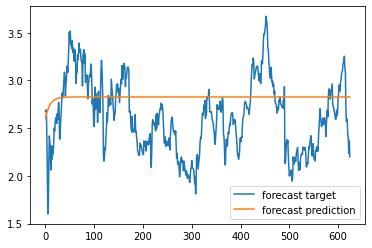

In [26]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

So, this is bad and not working. On the one step it is predicting the previous value, on the multi step it is a const.

Next we will try to predict the "return" price.

In [27]:
# Calculate returns by first shifting the data
df['PrevClose'] = df['close'].shift(1) # move everything up 1

# so now it's like
# close / prev close
# x[2] x[1]
# x[3] x[2]
# x[4] x[3]
# ...
# x[t] x[t-1]

In [28]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [29]:
# Then the return is
# (x[t] - x[t-1] / x[t-1])
df['Return'] = (df['close'] - df['PrevClose']) / df ['PrevClose']

In [30]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


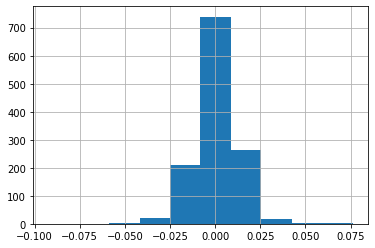

In [31]:
# Now lets try LSTM to predict returns
df['Return'].hist()

In [32]:
series = df['Return'].values[1:].reshape(-1, 1)

# Normalize the data
# Note: Here we do not bother where the true boundary is, this is just approx

scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [34]:
# Build the dataset

T = 10
D = 1
X = []
Y = []

for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Data is N x T x D
Y = np.array(Y)
N = len(X)

print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1248, 10, 1) Y.shape (1248,)


In [35]:
# Autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(loss='mse', optimizer=Adam(learning_rate=0.01))

# Train the RNN
r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs=80,
    validation_data=(X[-N//2:], Y[-N//2:])
)

Epoch 1/80
20/20 [==============================] - 2s 27ms/step - loss: 0.9939 - val_loss: 1.1609
Epoch 2/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9866 - val_loss: 1.1539
Epoch 3/80
20/20 [==============================] - 0s 9ms/step - loss: 0.9847 - val_loss: 1.1519
Epoch 4/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9834 - val_loss: 1.1556
Epoch 5/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9830 - val_loss: 1.1494
Epoch 6/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9822 - val_loss: 1.1465
Epoch 7/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9808 - val_loss: 1.1539
Epoch 8/80
20/20 [==============================] - 0s 9ms/step - loss: 0.9835 - val_loss: 1.1585
Epoch 9/80
20/20 [==============================] - 0s 8ms/step - loss: 0.9867 - val_loss: 1.1450
Epoch 10/80
20/20 [==============================] - 0s 9ms/step - loss: 0.9824 - val_loss: 1.1556
Epoch 11/80
20/20 

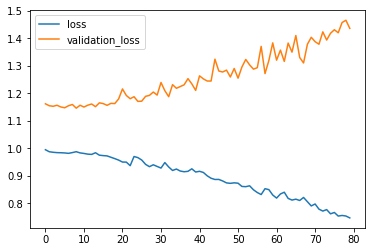

In [37]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='validation_loss')
plt.legend()

(1248, 1)


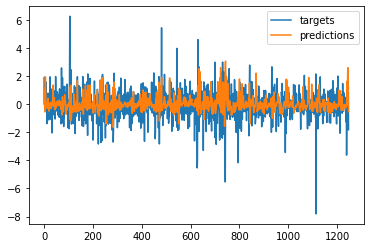

In [39]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

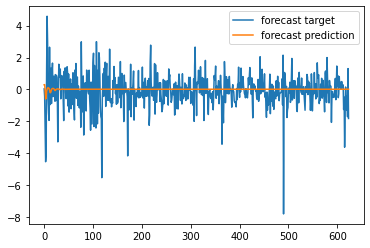

In [40]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

When we see that this doesn't give us good results - lest try something easier. Instead of regression problem make it a binary classification problem. Does the return go up or down?

In [41]:
# Turn everything into numpy arr
input_data = df[['open', 'high', 'low', 'close', 'volume']].values
targets = df['Return'].values

In [58]:
# Make the actial data that will go into a NN
T = 10 # The number of time steps to look at to make a prediction for the next day
D = input_data.shape[1]
N = len(input_data) - T # eg. if T = 10 and we have 11 data points then we'd have only 1 sample 

In [49]:
# normalize the inputs
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

In [59]:
# Setup X_train and Y_train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)

In [60]:
# Setup X_test and Y_test
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N - Ntrain)

for u in range(N - Ntrain):
  # u counts from 0...(N - Ntrain)
  # t counts from Ntrain...N
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)

In [61]:
# Make the RNN
i = Input(shape=(T, D))
x = LSTM(50)(i)
x - Dense(1, activation='sigmoid')(x)

model = Model(i, x)
model.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=0.001), 
              metrics=['accuracy'])

# Train
r = model.fit(
    X_train, Y_train,
    batch_size = 32,
    epochs=300,
    validation_data=(X_test, Y_test)
)

27/27 [==============================] - 0s 9ms/step - loss: 0.6914 - accuracy: 0.0048 - val_loss: 0.6950 - val_accuracy: 0.0000e+00
Epoch 135/300
27/27 [==============================] - 0s 9ms/step - loss: 0.6910 - accuracy: 0.0036 - val_loss: 0.6933 - val_accuracy: 0.0000e+00
Epoch 136/300
27/27 [==============================] - 0s 8ms/step - loss: 0.6907 - accuracy: 0.0012 - val_loss: 0.6942 - val_accuracy: 0.0000e+00
Epoch 137/300
27/27 [==============================] - 0s 9ms/step - loss: 0.6910 - accuracy: 0.0060 - val_loss: 0.6959 - val_accuracy: 0.0000e+00
Epoch 138/300
27/27 [==============================] - 0s 8ms/step - loss: 0.6942 - accuracy: 0.0048 - val_loss: 0.6943 - val_accuracy: 0.0000e+00
Epoch 139/300
27/27 [==============================] - 0s 10ms/step - loss: 0.6919 - accuracy: 0.0036 - val_loss: 0.6944 - val_accuracy: 0.0000e+00
Epoch 140/300
27/27 [==============================] - 0s 10ms/step - loss: 0.6908 - accuracy: 0.0072 - val_loss: 0.6948 - val_accu

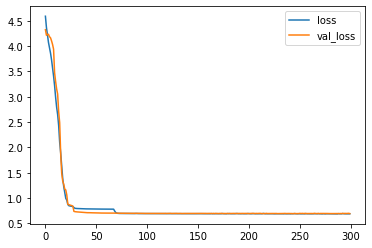

In [62]:
# plot the loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

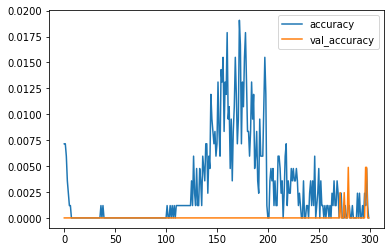

In [63]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

=> Not so easy to predict stock prices
